## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

In [52]:
flights_6 = pd.read_csv('flights_data.csv', low_memory=False)

In [53]:
#pulling out states names 
flights_6[['origin_city_name','state']] = flights_6["origin_city_name"].str.split(',',expand=True)

In [55]:
#creating df with 2 columns
flights_data_2 = flights_6[['origin_city_name','state']]
flights_data_2 = flights_data_2[['state']].groupby('state').agg(state_count = ('state', 'size')).reset_index()

In [56]:
#new column for percent
summ = flights_data_2['state_count'].sum()
flights_data_2['percent'] = (flights_data_2['state_count']/summ*100)
flights_data_2 = flights_data_2.sort_values('percent', ascending=False)

In [57]:
flights_data_2['percent_cumulative'] = flights_data_2['percent'].copy()
flights_data_2['percent_cumulative'] = flights_data_2['percent_cumulative'].cumsum()
flights_data_2 = flights_data_2[flights_data_2['percent_cumulative'] <= 50.9]

In [58]:
print(flights_data_2 )

   state  state_count    percent  percent_cumulative
4     CA        37009  11.525765           11.525765
44    TX        32802  10.215573           21.741338
8     FL        26069   8.118705           29.860043
13    IL        20286   6.317697           36.177740
9     GA        16184   5.040206           41.217946
26    NC        14636   4.558110           45.776056
33    NY        14631   4.556553           50.332609


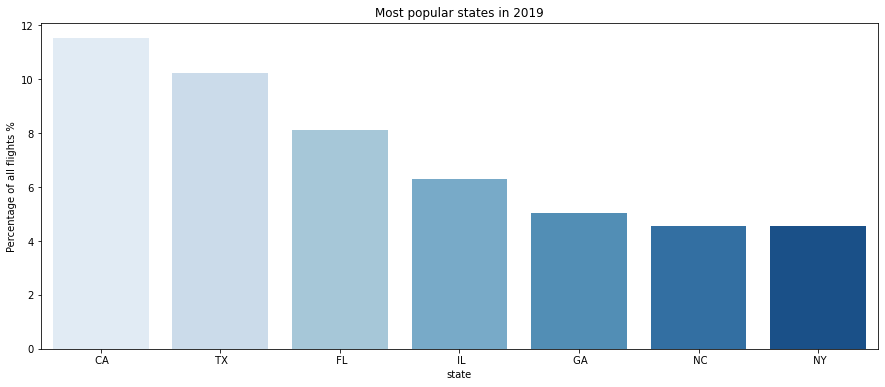

In [80]:
x = flights_data_2['state']
y = flights_data_2['percent']

fig = plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="Blues")
plt.title("Most popular states in 2019")
plt.ylabel("Percentage of all flights %")
plt.show()

In [60]:
print(len(flights_data_2))

7


In [81]:
fig.savefig('Most popular states')

7 states cover 50% of most popular US air traffic. These states are California, Texas, Florida, Illinois
Georgia, North Carolina and New York.

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

If null hypothesis that planes fly faster when there is the departure delay is true, then departure delay > arrival delay

In [89]:
flights_7 = pd.read_csv('flights_data.csv', low_memory=False)
#excluding diverted and canceled planes
flights_7 = flights_7[flights_7['diverted'] != 1]
flights_7 = flights_7[flights_7['cancelled'] != 1]

In [90]:
#dropping early departures
flights_7.drop(flights_7[flights_7.dep_delay < 0].index, inplace=True)

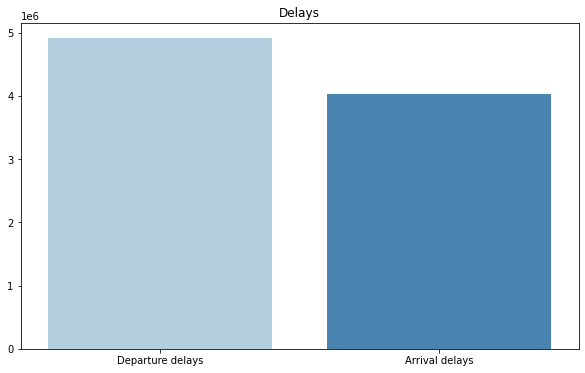

In [94]:
x = ["Departure delays", "Arrival delays"]
y = [flights_7['dep_delay'].sum(),flights_7['arr_delay'].sum()]

fig = plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, palette="Blues")
plt.title("Delays")
plt.show()

In [92]:
x = flights_7['dep_delay'].sum()/flights_7['arr_delay'].sum()
print(x)

1.2201523473806415


In [95]:
fig.savefig('Delays')

Planes fly faster when there is the departure delay

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [5]:
flights_data = pd.read_csv('flights_data.csv', low_memory=False)

In [6]:
# adding new column 'hour'

flights_data.dropna(subset=['dep_time', 'air_time'], inplace=True)
flights_data['hour'] = flights_data['dep_time'].floordiv(100).astype(int)

In [7]:
# adding new column 'flight_length'
# 1 for Short-Haul from 30 minutes to 3 hours
# 2 for Medium-Haul 3-6 hours
# 3 for Long-Haul over 6 hours
flights_data['flight_length'] = flights_data['air_time'].copy()
flights_data['flight_length'].mask(flights_data['flight_length'] < 180, 1, inplace=True)
flights_data['flight_length'].mask((flights_data['flight_length'] >= 180) & (flights_data['flight_length'] < 360), 2, inplace=True)
flights_data['flight_length'].mask(flights_data['flight_length'] >= 360, 3, inplace=True)

In [8]:
df_8 = flights_data[['flight_length', 'hour']].copy()

print(df_8[df_8['flight_length'] == 1.].mode())
print(df_8[df_8['flight_length'] == 2.].mode())
print(df_8[df_8['flight_length'] == 3.].mode())

   flight_length  hour
0            1.0    17
   flight_length  hour
0            2.0     8
   flight_length  hour
0            3.0    11


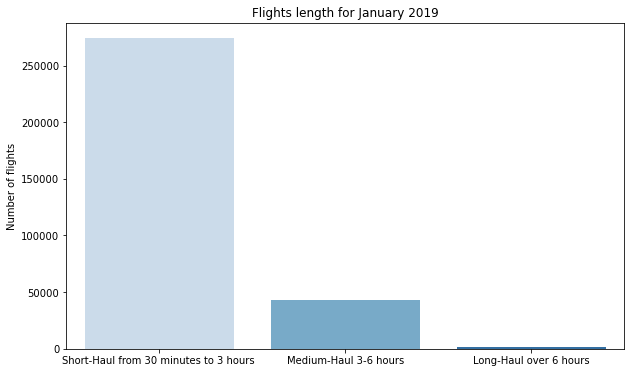

In [87]:
x = ["Short-Haul from 30 minutes to 3 hours ","Medium-Haul 3-6 hours","Long-Haul over 6 hours"]
y = [len(df_8[df_8['flight_length'] == 1.]),len(df_8[df_8['flight_length'] == 2.]), len(df_8[df_8['flight_length'] == 3.])]

fig = plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, palette="Blues")
plt.title("Flights length for January 2019")
plt.ylabel("Number of flights")
plt.show()

In [88]:
fig.savefig('Flights length')

Most short-haul flights take off at 5 pm, medium-haul flights at 8 am, long-haul flights at 11 am. Most of the flights are short-haul flights.

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [10]:
# top 10 busiest airports by flights count

flights_data = pd.read_csv('flights_data.csv', low_memory=False)
df_9 = flights_data[['origin', 'flights']].copy()
df_9 = df_9.groupby('origin').agg(flights_count = ('flights', 'size')).reset_index().sort_values('flights_count', ascending=False)
print(df_9[0:10])

    origin  flights_count
248    ORD          15798
20     ATL          15249
90     DFW          12108
89     DEN          11284
188    LAX          10878
69     CLT          10367
262    PHX           7890
312    SFO           7714
310    SEA           7699
161    IAH           7685


In [11]:
#top 10 busiest airports by passengers count

passengers = pd.read_csv('passengers.csv')
passengers.columns =['departures_scheduled', 'departures_performed', 'payload', 'seats', 'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time', 'unique_carrier', 'airline_id', 'unique_carrier_name', 'region', 'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new', 'origin_airport_id', 'origin_city_market_id', 'origin', 'origin_city_name', 'origin_country', 'origin_country_name', 'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name', 'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type', 'aircraft_config', 'month', 'year', 'distance_group', 'class','test']
passengers = passengers[['origin', 'passengers']]
passengers_2 = passengers.groupby('origin').agg(passengers_count = ('passengers', 'size')).reset_index().sort_values('passengers_count', ascending=False)
print(passengers_2[0:10])

    origin  passengers_count
905    ORD              5801
81     ATL              4325
312    DEN              4216
687    LAX              3766
553    IAH              3303
313    DFW              3155
785    MIA              3077
387    EWR              3005
818    MSP              2874
340    DTW              2760


It's not always the biggest number of flights mean that the biggest number of passengers went through the particular airport.

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

* Average monthly delay per air carrier

In [21]:
flights_data_10 = pd.read_csv('flights_data_all_2019_Months.csv')

In [22]:
#extracting month
flights_data_10['month'] = pd.DatetimeIndex(flights_data_10['fl_date']).month

In [23]:
#calculating all delays
flights_data_10[['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]] = flights_data_10[['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]].fillna(0)
flights_data_10['all delays'] = flights_data_10['arr_delay'] + flights_data_10['carrier_delay'] + flights_data_10['weather_delay'] + flights_data_10['nas_delay'] + flights_data_10['security_delay'] + flights_data_10['late_aircraft_delay']

In [24]:
#taking 3 columns
flights_data_10 = flights_data_10[['mkt_carrier','month', 'all delays' ]]

In [25]:
#group by each month average
flights_data_10 = flights_data_10.groupby(['mkt_carrier', 'month']).agg(monthly_delay = ('all delays', 'mean')).reset_index()

In [26]:
#average monthly delay
flights_data_10 = flights_data_10.groupby(['mkt_carrier']).agg(av_monthly_delay = ('monthly_delay', 'mean')).reset_index()
print(flights_data_10)

  mkt_carrier  av_monthly_delay
0          AA         19.452724
1          AS         10.393595
2          B6         30.304836
3          DL         13.836833
4          F9         25.069847
5          G4         22.008813
6          HA          5.833097
7          NK         17.998756
8          UA         27.839708
9          WN         10.837246


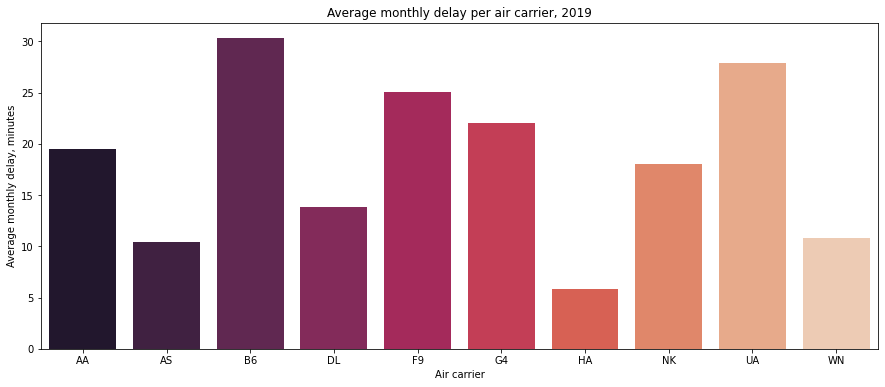

In [28]:
x = flights_data_10['mkt_carrier']
y = flights_data_10['av_monthly_delay']

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Average monthly delay per air carrier, 2019")
plt.ylabel("Average monthly delay, minutes")
plt.xlabel("Air carrier")
plt.show()

* Percent of extreme weather delays

In [63]:
flights_data_weather = pd.read_csv('flights_data_all_2019_Months.csv')
flights_data_weather[['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]] = flights_data_weather[['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]].fillna(0)
flights_data_weather['all delays'] = flights_data_weather['arr_delay'] + flights_data_weather['carrier_delay'] + flights_data_weather['weather_delay'] + flights_data_weather['nas_delay'] + flights_data_weather['security_delay'] + flights_data_weather['late_aircraft_delay']

print((((flights_data_weather['weather_delay'].sum()) / (flights_data_weather['all delays'].sum())) *100).round(2))

3.59


Extreme weather accounted for only 3.59% of all delays in 2019.

* Distance covered monthly by different air carriers

In [40]:
flights_data_10_2 = pd.read_csv('flights_data_all_2019_Months.csv')

In [41]:
#extracting month
flights_data_10_2['month'] = pd.DatetimeIndex(flights_data_10_2['fl_date']).month

In [42]:
#checking null values
flights_data_10_2['distance'].isnull().sum()

0

In [43]:
#taking 3 columns
flights_data_10_2 = flights_data_10_2[['mkt_carrier','month', 'distance' ]]

In [44]:
#group by each month distance (sum)
flights_data_10_2 = flights_data_10_2.groupby(['mkt_carrier', 'month']).agg(monthly_distance = ('distance', 'sum')).reset_index()

In [45]:
#average distance covered monthly by different air carriers
flights_data_10_2 = flights_data_10_2.groupby(['mkt_carrier']).agg(av_monthly_distance = ('monthly_distance', 'mean')).reset_index()
flights_data_10_2['av_monthly_distance'] = flights_data_10_2['av_monthly_distance'].astype(int)
print(flights_data_10_2)

  mkt_carrier  av_monthly_distance
0          AA              4522003
1          AS              1357462
2          B6              1044995
3          DL              3808326
4          F9               419391
5          G4               286758
6          HA               196295
7          NK               626652
8          UA              3848613
9          WN              3109201


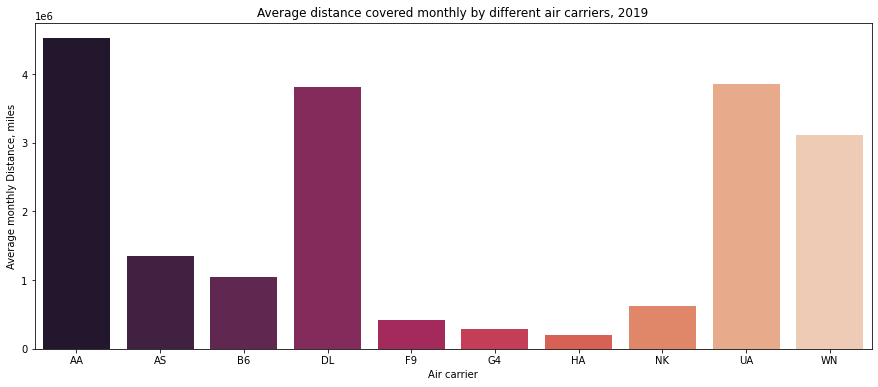

In [49]:
x = flights_data_10_2['mkt_carrier']
y = flights_data_10_2['av_monthly_distance'].astype(int)

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Average distance covered monthly by different air carriers, 2019")
plt.ylabel("Average monthly Distance, miles")
plt.xlabel("Air carrier")
plt.show()

* Find out number of passengers that were carried by different air carriers

In [70]:
# carriers from flights table
flights_data_car = pd.read_csv('flights_data_all_2019_Months.csv')
flights_data_car['mkt_carrier'].unique()

array(['AS', 'B6', 'AA', 'DL', 'UA', 'NK', 'WN', 'HA', 'G4', 'F9'],
      dtype=object)

In [74]:
# carriers from passengers table
passengers_all_car = pd.read_csv('passengers_all_2019.csv')
passengers_all_car = passengers_all_car[['passengers', 'month', 'carrier']]

# carriers unique values from flights table for passengers table
passengers_all_car.loc[passengers_all_car['carrier'].isin(['AS' 'B6' 'AA' 'DL' 'UA' 'NK' 'WN' 'HA' 'G4' 'F9'])]

,passengers,month,carrier


In [75]:
# group by each month average
passengers_all_car = passengers_all_car.groupby(['carrier', 'month']).agg(monthly_passengers = ('passengers', 'sum')).reset_index()

In [76]:
# average monthly number of passengers that were carried by different air carriers
passengers_all_car = passengers_all_car.groupby(['carrier']).agg(av_monthly_passengers = ('monthly_passengers', 'mean')).reset_index()
passengers_all_car['av_monthly_passengers'] = passengers_all_car['av_monthly_passengers'].astype(int)

print(passengers_all_car)

    carrier  av_monthly_passengers
0       02Q                    295
1       04Q                   3774
2       07Q                  10577
3       09Q                 125286
4       0BQ                      6
..      ...                    ...
318      YX                1573243
319      Z3                    555
320     Z3Q                   2592
321      ZW                 342195
322      ZX                  72611

[323 rows x 2 columns]
